In [66]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
import numpy as np

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/kurs_idr_chf.csv")
df

,Tanggal,CHF
0,31/01/2001,"5,743.64"
1,28/02/2001,"5,856.44"
2,31/03/2001,"6,014.00"
3,30/04/2001,"6,767.74"
4,31/05/2001,"6,210.98"
...,...,...
272,30/09/2023,"16,942.00"
273,31/10/2023,"17,608.17"
274,30/11/2023,"17,528.63"
275,31/12/2023,"18,374.28"


In [69]:
def load_data(file):
    df = pd.read_csv(file,
    index_col=["Tanggal"],
    usecols=["Tanggal","CHF"])
    df.index = pd.to_datetime(df.index)
    return df

df

,Tanggal,CHF
0,31/01/2001,"5,743.64"
1,28/02/2001,"5,856.44"
2,31/03/2001,"6,014.00"
3,30/04/2001,"6,767.74"
4,31/05/2001,"6,210.98"
...,...,...
272,30/09/2023,"16,942.00"
273,31/10/2023,"17,608.17"
274,30/11/2023,"17,528.63"
275,31/12/2023,"18,374.28"


In [70]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [71]:
# Memanggil fungsi series_to_supervised dengan parameter tertentu
result = series_to_supervised(df, n_in=1, n_out=1, dropnan=True)
print(result)

      var1(t-1)  var2(t-1)     var1(t)    var2(t)
1    31/01/2001   5,743.64  28/02/2001   5,856.44
2    28/02/2001   5,856.44  31/03/2001   6,014.00
3    31/03/2001   6,014.00  30/04/2001   6,767.74
4    30/04/2001   6,767.74  31/05/2001   6,210.98
5    31/05/2001   6,210.98  30/06/2001   6,352.74
..          ...        ...         ...        ...
272  31/08/2023  17,316.00  30/09/2023  16,942.00
273  30/09/2023  16,942.00  31/10/2023  17,608.17
274  31/10/2023  17,608.17  30/11/2023  17,528.63
275  30/11/2023  17,528.63  31/12/2023  18,374.28
276  31/12/2023  18,374.28  31/01/2024  18,346.00

[276 rows x 4 columns]


In [72]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    return scaler, data_scaled

In [73]:
def inverse_normdata(scaler, dataX, yhat):
    dataX = dataX.reshape((dataX.shape[0], dataX.shape[2]))
    inv_y = np.concatenate((dataX, yhat), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, -1]
    return inv_y

In [74]:
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.models import Sequential

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import concat
from sklearn.preprocessing import MinMaxScaler

In [75]:
# RNN
def build_model(train_X):
    model = Sequential()

    model.add(SimpleRNN(256, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(Dropout(0.3))

    model.add(SimpleRNN(256, return_sequences=True))
    model.add(Dropout(0.3))

    model.add(SimpleRNN(256))
    model.add(Dropout(0.3))

    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.compile(loss="mse", optimizer="adam")

    return model

(264, 1, 1)
train_X shape = (264, 1, 1), train_y shape = (264, 1), test_X shape = (12, 1, 1), test_y shape = (12, 1)


<ipython-input-69-e9ba52fb2127>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df.index = pd.to_datetime(df.index)


Epoch 1/100
1/1 - 3s - loss: 0.0737 - val_loss: 0.0705 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 0.0665 - val_loss: 0.0482 - 48ms/epoch - 48ms/step
Epoch 3/100
1/1 - 0s - loss: 0.0641 - val_loss: 0.0597 - 51ms/epoch - 51ms/step
Epoch 4/100
1/1 - 0s - loss: 0.0593 - val_loss: 0.0806 - 46ms/epoch - 46ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0548 - val_loss: 0.0941 - 47ms/epoch - 47ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0512 - val_loss: 0.0893 - 46ms/epoch - 46ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0469 - val_loss: 0.0679 - 59ms/epoch - 59ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0379 - val_loss: 0.0443 - 46ms/epoch - 46ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0324 - val_loss: 0.0260 - 48ms/epoch - 48ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0247 - val_loss: 0.0182 - 48ms/epoch - 48ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0185 - val_loss: 0.0169 - 59ms/epoch - 59ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0115 - val_loss: 0.0179 - 48ms/epoch - 48ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0076 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


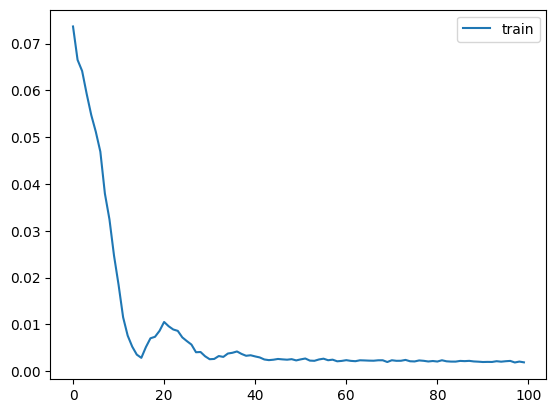

1/1 [==============================] - 0s 21ms/step


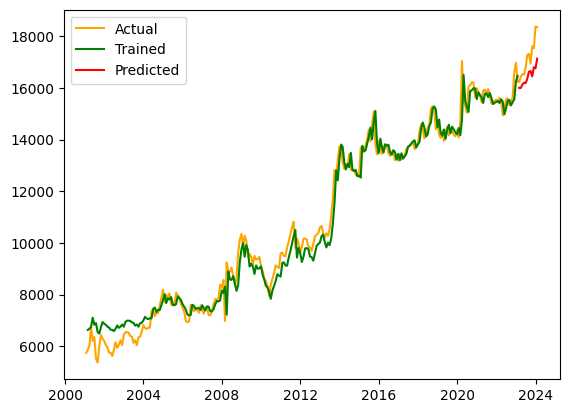

Test RMSE normal : 828.604
Test MSE normal : 686584.421


In [76]:
if __name__=='__main__':

    df = load_data("/content/drive/MyDrive/Colab Notebooks/kurs_idr_chf.csv")
    df['CHF']=pd.to_numeric(df['CHF'].str.replace(',', ''))
    # reframe data menjadi supervised
    data_reframed = series_to_supervised(df, 1, 1)
    df_data_reframed = pd.DataFrame(data_reframed)

    # scale data menjadi range 0-1
    scaler, data_scaled = normalize_data(data_reframed.values)
    df_data_scaled = pd.DataFrame(data_scaled, index=df_data_reframed.index, columns=df_data_reframed.columns)

    # splitting data
    # porsi_training = 80% trainin, 20% testing
    n_split = len(df_data_scaled) * 0.9565217391304348
    n = int(n_split)

    train = df_data_scaled.iloc[:n, :]
    test = df_data_scaled.iloc[n:, :]

    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
    train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))

    print(train_X.shape)


    train_y = pd.DataFrame(train_y)
    test_y = pd.DataFrame(test_y)

    print("train_X shape = %s, train_y shape = %s, test_X shape = %s, test_y shape = %s" % (train_X.shape, train_y.shape, test_X.shape, test_y.shape))

    model = build_model(train_X)

    history = model.fit(train_X, train_y, epochs=100, batch_size=len(train_X), validation_data=(test_X, test_y),
                        verbose=2, shuffle=False)
    model.save("rnn_model.h5")

    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()

    # plot model and train data
    y_train = model.predict(train_X)
    inv_ymodel = inverse_normdata(scaler, train_X, y_train)
    df_inv_ymodel = pd.DataFrame(inv_ymodel, index=train_y.index)

    # plot test data
    y_test = model.predict(test_X)
    inv_y_test = inverse_normdata(scaler, test_X, y_test)

    df_inv_ytest = pd.DataFrame(inv_y_test, index=test_y.index)
    plt.plot(df, color='orange', label='Actual')
    plt.plot(df_inv_ymodel, color='green', label='Trained')
    plt.plot(df_inv_ytest, color='red', label='Predicted')
    plt.legend()
    plt.show()

    # inverse data dari 0-1 menjadi range awal
    inv_test_y = inverse_normdata(scaler, test_X, test_y)
    rmse_normal = sqrt(mean_squared_error(inv_test_y, inv_y_test))
    print('Test RMSE normal : %.3f' % rmse_normal)
    print('Test MSE normal : %.3f' % mean_squared_error(inv_test_y, inv_y_test))